<a href="https://colab.research.google.com/github/schen304joseph/team3.github.io/blob/main/Design_Optimization_Stiffness.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TEAM 3 DYNAMICS II 

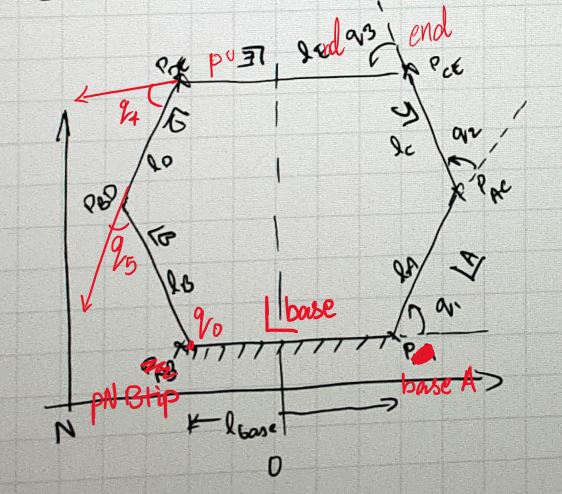

The Dynamics model shown in the figure above represents the sarrus mechanism used for our system to achieve motion of calf muscle during the human running gate cycle. The exterioir axis represents the Newtonian frame and the 6 links represent the frames of references. All of the link vectors are relative to the Newtonian frame shown in the figure. 


Our team’s mechanism is intended to perform calf muscle motion using the foldable concepts we learned in class. The motion is driven through sarrus linkages to expand and contract. To measure this, we would need to start the device at a specific zero point, with sarrus linkages to a initial position.
Success is optimized joint stiffness and the distance traveled in the y-direction. 
The performance metric that our team is focusing on is the joint stiffness. This realtes to our research question by answering the question if we can design a artificial mechanism which is compliant with the actual properties of calf muscles during expansion and contraction during human running gate cycle.  

In [ ]:
%matplotlib inline

In [ ]:
#pip install pynamics

In [ ]:
#import packages
use_constraints = True

import pynamics
from pynamics.frame import Frame
from pynamics.variable_types import Differentiable,Constant,Variable
from pynamics.system import System
from pynamics.body import Body
from pynamics.dyadic import Dyadic
from pynamics.output import Output,PointsOutput
from pynamics.particle import Particle
from pynamics.constraint import KinematicConstraint,AccelerationConstraint
import pynamics.tanh
import pynamics.integration
import numpy
import sympy
from sympy import sin
import scipy.optimize
import matplotlib.pyplot as plt
plt.ion()
from math import pi

In [ ]:
#pip install cma

In [ ]:
# Additional libraries for optimization
import logging
import pynamics.system
import numpy.random
import scipy.interpolate
import scipy.optimize
import cma

In [ ]:
system = System()
pynamics.set_system(__name__,system)

## Procedure and Discussion

#### 1. Scale: Ensure your system is using SI units. You should be specifying lengths in meters (so millimeters should be scaled down to the .001 range), forces in Newtons, and radians (not degrees), and masses in kg. You may make educated guesses about mass for now.

Declaring all the constants using SI units.
The length of each link can be obtained using the kinematics model. The units of dynamics were scaled to avoid any numerical error or the solver to diverge. The top and bottom links have twice the parameters as compared to the other four links on the side. The masses are estimated values of the links.

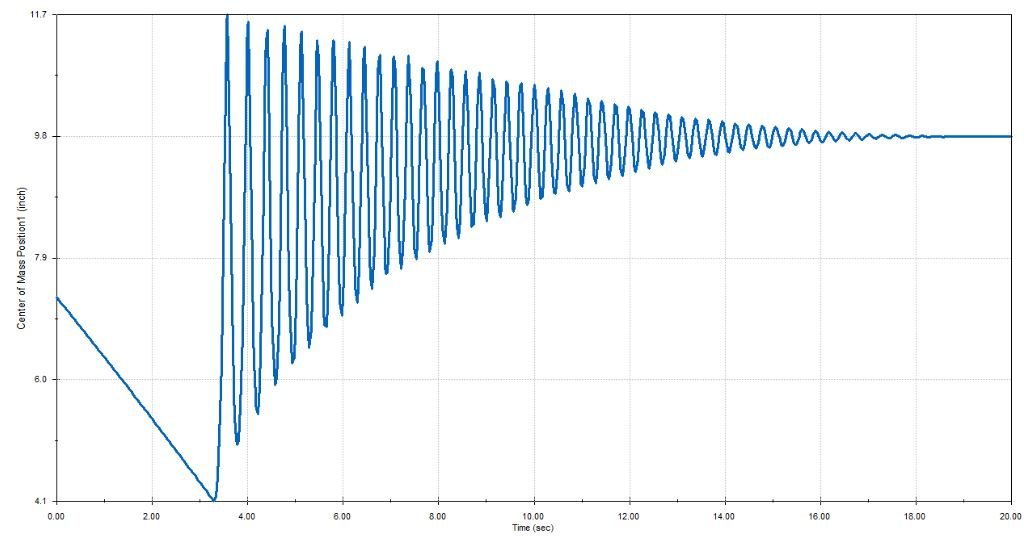

The experiment's goal is to find the damping factor of the system using Solidworks motion analysis. Based on our design, the actuator will rotate the links to compress the robot structure and extend the top. 
Free vibration trace measurements show a 13% reduction in vibration amplitude after 27 cycles. At the time 3.59 seconds, the displacement was 11.7 inches, and it decreased to 10.2 at 11.67 seconds. The decline link from 0 to 3.27 seconds was when the actuator compressed the robot. Based on the calculation, the damping coefficient is 0.0041. 

**Note: for optimization purpose we will be using negligible damping to make our calculations easy. This damping factor will be included in final manufacturing design and Dynamics code. 

This description walks through how we used our dynamics II code to optimize the joint stiffness value. The code already has weight and forces to restrict the system, so we can change stiffness and see how the system reacts. For our optimization problem we need to tune the k value(stiffness) such that there is more motion in the y direction. 
Maximum motion in the y is our desired outcome that we seek to maximize based on the mechanism. Using our dynamics II code.

Kmax = Force/angle of rotation
displacement in y direction = 1.5" (0.0381m) (full motion)
Force = 0.220 Nm

In [ ]:
#Link lengths
lbase = Constant(0.035,'lbase',system)
lA = Constant(0.07,'lA',system)
lC = Constant(0.07,'lC',system)
lend = Constant(0.035,'lend',system)
lD = Constant(0.07,'lD',system)
lB = Constant(0.07,'lB',system)

#Link Masses calculating using the size of the link (length X width) (meter) and the approximate density (rho = kg/m^3) of Cardstock which was found as follows:
length = 0.07
width = 0.035
thickness = 0.0012
rho = 690 
m = length*width*thickness*rho
motor_mass = 0.0134 #kg

mbase = Constant(m/2,'mbase',system)
mA = Constant(m,'mA',system)
mC = Constant(m,'mC',system)
mend = Constant(m/2,'mend',system)
mD = Constant(m,'mD',system)
mB = Constant(m,'mB',system)

g = Constant(9.81,'g',system)
b = Constant(1e1,'b',system)

# Here we are using an initial guess for stiffness for the optimization model.
k = Constant(1e1,'k',system)

#Adding spring preloads for all the links to establish neutral point
preload0 = Constant(0*pi/180,'preload0',system)
preload1 = Constant(0*pi/180,'preload1',system)
preload2 = Constant(0*pi/180,'preload2',system)
preload3 = Constant(0*pi/180,'preload3',system)
preload4 = Constant(0*pi/180,'preload4',system)
preload5 = Constant(0*pi/180,'preload5',system)

#Defining inertia of each frame
Ixx_base = Constant(1,'Ixx_base',system)
Iyy_base = Constant(1,'Iyy_base',system)
Izz_base = Constant(1,'Izz_base',system)
Ixx_A = Constant(1,'Ixx_A',system)
Iyy_A = Constant(1,'Iyy_A',system)
Izz_A = Constant(1,'Izz_A',system)
Ixx_B = Constant(1,'Ixx_B',system)
Iyy_B = Constant(1,'Iyy_B',system)
Izz_B = Constant(1,'Izz_B',system)
Ixx_C = Constant(1,'Ixx_C',system)
Iyy_C = Constant(1,'Iyy_C',system)
Izz_C = Constant(1,'Izz_C',system)
Ixx_D = Constant(1,'Ixx_D',system)
Iyy_D = Constant(1,'Iyy_D',system)
Izz_D = Constant(1,'Izz_D',system)
Ixx_end = Constant(1,'Ixx_end',system)
Iyy_end = Constant(1,'Iyy_end',system)
Izz_end = Constant(1,'Izz_end',system)

Additional variables x1 and y1 (and their derivatives) are created to break free from the Newtonian Frame and create a moving system. These measure the distance of the joint of links D and link end (PendD) from the origin in the Nx and Ny direction.

In [ ]:
# Create the differentiable state variables, corresponding to the joint angles
# Position of y1 which is at midpoint.
#y1,y1_d,y1_dd = Differentiable('y1',system)

q0,q0_d,q0_dd = Differentiable('q0',system)
q1,q1_d,q1_dd = Differentiable('q1',system)
q2,q2_d,q2_dd = Differentiable('q2',system)
q3,q3_d,q3_dd = Differentiable('q3',system)
q4,q4_d,q4_dd = Differentiable('q4',system)
q5,q5_d,q5_dd = Differentiable('q5',system)


The time frame is set to end once the system has maintained a Steady State. Time step is set to be 1 step per frame at 30 frames a second (1/30). Integration Tolerance is set to 1e-4 to keep some integration accuracy, while allowing a quicker integration time.

In [ ]:
# Specifying how precise the integration should perform
# Defining the variables for time to be used in the script
tol = 1e-6
tinitial = 0
tfinal = 5
fps = 30
tstep = 1/fps
t = numpy.r_[tinitial:tfinal:tstep]

In [ ]:
# Initial guesses for the meachanism starting point
initialvalues = {}
initialvalues[q0] = 0*pi/180
initialvalues[q0_d] = 0*pi/180
initialvalues[q1]=45*pi/180          
initialvalues[q1_d]=0*pi/180
initialvalues[q2]=90*pi/180         
initialvalues[q2_d]=0*pi/180
initialvalues[q3]=45*pi/180           
initialvalues[q3_d]=0*pi/180
initialvalues[q4]=45*pi/180
initialvalues[q4_d]=0*pi/180
initialvalues[q5]=90*pi/180
initialvalues[q5_d]=0*pi/180

#Frame contact initial points
#initialvalues[y1]=0.15
#initialvalues[y1_d]=0

In [ ]:
# This helps to order the initial values in a list in a way so that the integrator can use it in the same order that it excepts to be supplied.   
statevariables = system.get_state_variables()
ini = [initialvalues[item] for item in statevariables]

In [ ]:
N = Frame('N',system)
base = Frame('base',system)
A = Frame('A',system)
C = Frame('C',system)
end = Frame('end',system)
D = Frame('D',system)
B = Frame('B',system)

In [ ]:
system.set_newtonian(N)


In [ ]:
base.rotate_fixed_axis(N,[0,0,1],q0,system)
A.rotate_fixed_axis(base,[0,0,1],q1,system)
C.rotate_fixed_axis(A,[0,0,1],q2,system)
end.rotate_fixed_axis(C,[0,0,1],q3,system)
D.rotate_fixed_axis(end,[0,0,1],q4,system)
B.rotate_fixed_axis(D,[0,0,1],q5,system)

In [ ]:
pNbase= 0*N.x + 0*N.y + 0*N.z
pbaseA = pNbase + lbase*base.x
pAC= pbaseA + lA*A.x
pCend= pAC + lC*C.x
pendD= pCend + lend*end.x
pDB = pendD + lD*D.x
pNBtip = pDB + lB*B.x
#ps1 = pAcm - ls*A.x

In [ ]:
#points = [pNbase,pbaseA,pAC,pCend,pendD,pDB,pNBtip]
#statevariables = system.get_state_variables()
#ini0 = [initialvalues[item] for item in statevariables]

Defining Center of mass.

In [ ]:
pbasecm= pNbase + lbase/2*base.x
pAcm = pbaseA +lA/2*A.x
pCcm= pAC + lC/2*C.x 
pendcm= pCend + lend/2*end.x
pDcm= pendD + lD/2*D.x
pBcm= pDB + lB/2*B.x

In [ ]:
wNbase = N.get_w_to(base)
wbaseA = base.get_w_to(A)
wbaseB = base.get_w_to(B)
wAC = A.get_w_to(C)
wCend = C.get_w_to(end)
wendD = end.get_w_to(D)
wDB = D.get_w_to(B)

In [ ]:
#vFrame = pNbase.time_derivative()
#vTop = pendD.time_derivative()
#vbaseA = pbaseA.time_derivative()
#vNBtip = pNBtip.time_derivative()
vNBtip = pNBtip.time_derivative(N,system)

#### 2. Define Inertias: Add a center of mass and a particle or rigid body to each rotational frame. You may use particles for now if you are not sure of the inertial properties of your bodies, but you should plan on finding these values soon for any “payloads” or parts of your system that carry extra loads (other than the weight of paper).

Defining Inertias. We are adding center of mass and a particle to each rotational frame since we are not sure of the inertial properties of our bodies. 
The center of masses is located in the center of each link based on our current paper prototype.
We are using inertia values as 1 for all the links to help us aid with the calculations. More accurate values for the bodies will be provided in future assignments.   



In [ ]:
Ibase = Dyadic.build(N,Ixx_base,Iyy_base,Izz_base)
IA = Dyadic.build(A,Ixx_A,Iyy_A,Izz_A)
IB = Dyadic.build(B,Ixx_B,Iyy_B,Izz_B)
IC = Dyadic.build(C,Ixx_C,Iyy_C,Izz_C)
ID = Dyadic.build(D,Ixx_D,Iyy_D,Izz_D)
Iend = Dyadic.build(end,Ixx_end,Iyy_end,Izz_end)

Bodybase = Body('Bodybase',base,pbasecm,mbase,Ibase,system)
BodyA = Body('BodyA',A,pAcm,mA,IA,system)
BodyC = Body('BodyC',C,pCcm,mC,IC,system)
Bodyend = Body('Bodyend',end,pendcm,mend,Iend,system)
BodyD = Body('BodyD',D,pDcm,mD,ID,system)
BodyB = Body('BodyB',B,pBcm,mB,IB,system)

#### 3.Add Forces: Add the acceleration due to gravity. Add rotational springs in the joints (using k=0 is ok for now) and a damper to at least one rotational joint. You do not need to add external motor/spring forces but you should start planning to collect that data.

Adding Time dependent Motor Torque on the applied links. Torque is applied at joint PNbase.
Using the selected motor the max torque is 0.220 (N*m)


In [ ]:
#Add motor force
torque= Constant(0.220,'torque',system)
freq = Constant(3e0,'freq',system)


system.addforce(torque*sympy.sin(freq*2*sympy.pi*system.t)*A.z,wNbase)

In [ ]:
system.add_spring_force1(0,(q0-preload0)*N.z,wNbase)
system.add_spring_force1(0,(q1-preload1)*base.z,wbaseA)
system.add_spring_force1(k,(q2-preload2)*A.z,wAC)
system.add_spring_force1(k,(q3-preload3)*C.z,wCend)
system.add_spring_force1(k,(q4-preload4)*end.z,wendD)
system.add_spring_force1(k,(q5-preload5)*D.z,wDB)

(<pynamics.force.Force at 0x7f665de90f10>,
 <pynamics.spring.Spring at 0x7f665debfdd0>)

In [ ]:
system.addforce(0*wNbase,wNbase)
system.addforce(0*wbaseA,wbaseA)
#system.addforce(-b*wbaseB,wbaseB)
system.addforce(-b*wAC,wAC)
system.addforce(-b*wCend,wCend)
system.addforce(-b*wendD,wendD)
system.addforce(-b*wDB,wDB)

In [ ]:
system.addforcegravity(-g*N.y)

#### 4.Constraints: Keep mechanism constraints in, but follow the pendulum example of double-differentiating all constraint equations.

If you defined your mechanism as unattached to the Newtonian frame, add enough constraints so that it is fully attached to ground (for now). you will be eventually removing these constraints.
Constraints are defined to prevent motion of certain elements in the mechanism. The last link in the sarrus mechanism is connected pNBtip to the fixed ground and base. 
The center joint on the left side pDB is constrained to stay along the same height as the center joint on right side pAC
The base link is aslo grounded to the ground so that there is motion instead motion is only by the top (end) link.


The sarrus linkage mechanism have a specific joint stiffness associated with them. The joint stiffness is weak enough such that the motor is able to contract it , but strong enough to push the top link upwards to produce motion. 

The mechanism must be stiff enough to be able to push weights on the top link in order to perform as desired

In [ ]:
eq1 = [pNBtip - pNbase]
eq2 = [pDB - pAC]
eq3 = [pNbase - pbaseA]

In [ ]:
# Converting vector constraints into scalar quantities to make it solvable (Referring back to Solving Nonlinear Four-Bar Constraints Example )

eq = []

# pNBtip and base frame should be in the same x and y axis of N frame
eq.append((eq1[0]).dot(N.x))
eq.append((eq1[0]).dot(N.y))

# pCend and pendD should be in the same y axis from Newtonian frame
eq.append((eq2[0]).dot(end.y)) 

# pNbase and pbaseA are the same distance in y axis from the newtonian frame
eq.append((eq3[0]).dot(N.y))

    
#Adding Derivative constraints and substituing in the system constants    
eq_d = []
eq_d = [system.derivative(item) for item in eq]
    
eq_dd = []
eq_dd = [system.derivative(item) for item in eq_d]

    
system.add_constraint(AccelerationConstraint(eq_dd))

  
print(eq)

[-lA*sin(q0)*sin(q1) + lA*cos(q0)*cos(q1) + lB*(-(-sin(q0)*sin(q1) + cos(q0)*cos(q1))*sin(q2) + (-sin(q0)*cos(q1) - sin(q1)*cos(q0))*cos(q2))*((-sin(q4)*sin(q5) + cos(q4)*cos(q5))*sin(q3) + (sin(q4)*cos(q5) + sin(q5)*cos(q4))*cos(q3)) + lB*((-sin(q0)*sin(q1) + cos(q0)*cos(q1))*cos(q2) + (-sin(q0)*cos(q1) - sin(q1)*cos(q0))*sin(q2))*((-sin(q4)*sin(q5) + cos(q4)*cos(q5))*cos(q3) - (sin(q4)*cos(q5) + sin(q5)*cos(q4))*sin(q3)) + lC*(-sin(q0)*sin(q1) + cos(q0)*cos(q1))*cos(q2) + lC*(-sin(q0)*cos(q1) - sin(q1)*cos(q0))*sin(q2) + lD*(-(-sin(q0)*sin(q1) + cos(q0)*cos(q1))*sin(q2) + (-sin(q0)*cos(q1) - sin(q1)*cos(q0))*cos(q2))*(sin(q3)*cos(q4) + sin(q4)*cos(q3)) + lD*((-sin(q0)*sin(q1) + cos(q0)*cos(q1))*cos(q2) + (-sin(q0)*cos(q1) - sin(q1)*cos(q0))*sin(q2))*(-sin(q3)*sin(q4) + cos(q3)*cos(q4)) + lbase*cos(q0) + lend*(-sin(q0)*sin(q1) + cos(q0)*cos(q1))*(-sin(q2)*sin(q3) + cos(q2)*cos(q3)) + lend*(-sin(q0)*cos(q1) - sin(q1)*cos(q0))*(sin(q2)*cos(q3) + sin(q3)*cos(q2)), lA*sin(q0)*cos(q1) + lA

In [ ]:
# Identifying independent and dependent variables
qi = [q1]
qd = [q0,q2,q3,q4,q5]

In [ ]:
#Creating dictionary for independent variables
constants = system.constant_values.copy()
defined = dict([(item,initialvalues[item]) for item in qi])
constants.update(defined)

In [ ]:
eq = [item.subs(constants) for item in eq]
print(eq)

[0.07*((-sin(q4)*sin(q5) + cos(q4)*cos(q5))*sin(q3) + (sin(q4)*cos(q5) + sin(q5)*cos(q4))*cos(q3))*((-0.707106781186548*sin(q0) - 0.707106781186547*cos(q0))*cos(q2) - (-0.707106781186547*sin(q0) + 0.707106781186548*cos(q0))*sin(q2)) + 0.07*((-sin(q4)*sin(q5) + cos(q4)*cos(q5))*cos(q3) - (sin(q4)*cos(q5) + sin(q5)*cos(q4))*sin(q3))*((-0.707106781186548*sin(q0) - 0.707106781186547*cos(q0))*sin(q2) + (-0.707106781186547*sin(q0) + 0.707106781186548*cos(q0))*cos(q2)) + 0.07*((-0.707106781186548*sin(q0) - 0.707106781186547*cos(q0))*sin(q2) + (-0.707106781186547*sin(q0) + 0.707106781186548*cos(q0))*cos(q2))*(-sin(q3)*sin(q4) + cos(q3)*cos(q4)) + 0.07*((-0.707106781186548*sin(q0) - 0.707106781186547*cos(q0))*cos(q2) - (-0.707106781186547*sin(q0) + 0.707106781186548*cos(q0))*sin(q2))*(sin(q3)*cos(q4) + sin(q4)*cos(q3)) + 0.035*(-sin(q2)*sin(q3) + cos(q2)*cos(q3))*(-0.707106781186547*sin(q0) + 0.707106781186548*cos(q0)) + 0.035*(sin(q2)*cos(q3) + sin(q3)*cos(q2))*(-0.707106781186548*sin(q0) - 0.

In [ ]:
error = (numpy.array(eq)**2).sum()
f = sympy.lambdify(qd,error)

def function(args):
    return f(*args)

In [ ]:
guess = [initialvalues[item] for item in qd]
result = scipy.optimize.minimize(function,guess)
result

iniSolved = []
for item in system.get_state_variables():
    if item in qd:
        iniSolved.append(result.x[qd.index(item)])
    else:
        iniSolved.append(initialvalues[item])
system.get_state_variables()

[q0, q1, q2, q3, q4, q5, q0_d, q1_d, q2_d, q3_d, q4_d, q5_d]

2022-04-28 04:02:30,797 - pynamics.output - INFO - calculating outputs
2022-04-28 04:02:30,803 - pynamics.output - INFO - done calculating outputs


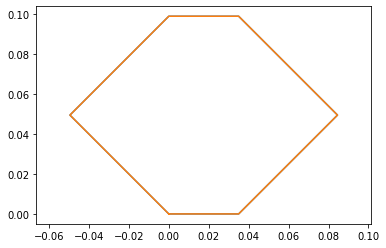

In [ ]:
points = [pNbase,pbaseA,pAC,pCend,pendD,pDB,pNBtip]
points_output = PointsOutput(points, constant_values=system.constant_values)
points = PointsOutput(points, constant_values=system.constant_values)
points.calc(numpy.array([ini,iniSolved]),numpy.array([0,1]))
points.plot_time()

#### 5. Solution: Add the code from the bottom of the pendulum example for solving for f=ma, integrating, plotting, and animating. Run the code to see your results. It should look similar to the pendulum example with constraints added, as in like a rag-doll or floppy

In [ ]:
f,ma = system.getdynamics()
print(f)
print(ma)

2022-04-28 04:02:31,163 - pynamics.system - INFO - getting dynamic equations


[g*lA*mA*sin(q0)*sin(q1)/2 - g*lA*mA*cos(q0)*cos(q1)/2 + g*lA*mB*sin(q0)*sin(q1) - g*lA*mB*cos(q0)*cos(q1) + g*lA*mC*sin(q0)*sin(q1) - g*lA*mC*cos(q0)*cos(q1) + g*lA*mD*sin(q0)*sin(q1) - g*lA*mD*cos(q0)*cos(q1) + g*lA*mend*sin(q0)*sin(q1) - g*lA*mend*cos(q0)*cos(q1) - g*lB*mB*((-sin(q0)*sin(q1) + cos(q0)*cos(q1))*sin(q2) + (sin(q0)*cos(q1) + sin(q1)*cos(q0))*cos(q2))*(-(-sin(q4)*sin(q5) + cos(q4)*cos(q5))*sin(q3) + (-sin(q4)*cos(q5) - sin(q5)*cos(q4))*cos(q3))/2 - g*lB*mB*((-sin(q0)*sin(q1) + cos(q0)*cos(q1))*cos(q2) - (sin(q0)*cos(q1) + sin(q1)*cos(q0))*sin(q2))*((-sin(q4)*sin(q5) + cos(q4)*cos(q5))*cos(q3) + (-sin(q4)*cos(q5) - sin(q5)*cos(q4))*sin(q3))/2 - g*lC*mB*(-sin(q1)*sin(q2) + cos(q1)*cos(q2))*cos(q0) - g*lC*mB*(-sin(q1)*cos(q2) - sin(q2)*cos(q1))*sin(q0) - g*lC*mC*(-sin(q1)*sin(q2) + cos(q1)*cos(q2))*cos(q0)/2 - g*lC*mC*(-sin(q1)*cos(q2) - sin(q2)*cos(q1))*sin(q0)/2 - g*lC*mD*(-sin(q1)*sin(q2) + cos(q1)*cos(q2))*cos(q0) - g*lC*mD*(-sin(q1)*cos(q2) - sin(q2)*cos(q1))*sin(q0) 

In [ ]:
unknown_constants = [k]

In [ ]:
known_constants = list(set(system.constant_values.keys())-set(unknown_constants))
known_constants = dict([(key,system.constant_values[key]) for key in known_constants])

In [ ]:
func1,lambda1 = system.state_space_post_invert(f,ma,return_lambda = True,constants = known_constants)

2022-04-28 04:02:40,251 - pynamics.system - INFO - solving a = f/m and creating function
2022-04-28 04:03:23,116 - pynamics.system - INFO - substituting constrained in Ma-f.
2022-04-28 04:04:32,284 - pynamics.system - INFO - done solving a = f/m and creating function
2022-04-28 04:04:32,291 - pynamics.system - INFO - calculating function for lambdas


In [ ]:
def run_sim(args):
    constants = dict([(key,value) for key,value in zip(unknown_constants,args)])
    states=pynamics.integration.integrate(func1,ini,t,rtol=tol,atol=tol,hmin=tol, args=({'constants':constants},))
    return states

In [ ]:
points = [pNbase,pbaseA,pAC,pCend,pendD,pDB,pNBtip]


In [ ]:
input_data = run_sim([1.1e2,9e2])

2022-04-28 05:02:06,416 - pynamics.integration - INFO - beginning integration
2022-04-28 05:02:10,820 - pynamics.integration - INFO - finished integration


2022-04-28 04:04:41,373 - pynamics.output - INFO - calculating outputs
2022-04-28 04:04:41,499 - pynamics.output - INFO - done calculating outputs


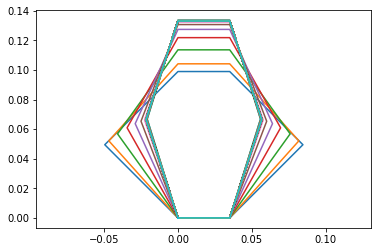

In [ ]:
points_output = PointsOutput(points,system)
y = points_output.calc(input_data,t)
points_output.plot_time()


In [ ]:
r = numpy.random.randn(*(y.shape))*.01
y_rand= y + r

In [ ]:
y = y.reshape((len(t),-1))
numpy.savetxt("data.csv", y, delimiter=",")

In [ ]:
y = numpy.genfromtxt('data.csv', delimiter=',')
fy = scipy.interpolate.interp1d(t,y.T,fill_value='extrapolate')
fyt = fy(t).T

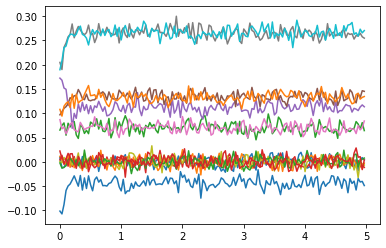

In [ ]:
plt.figure()
plt.plot(t,fyt)

As a team we determined our systems performance metric as the displacement in the y-direction. This is most important metric while answering our research question to decide the best manufacturing material for highest stiffness. It will help us to create a mechanism that will be able to expand and contract without failure to different body masses applied to it. The joints play an important role to provide maximum desirable motion in the y direction as the goal of our robot. 

In the model I have used the (scipy.optimize) optimization model to find the mainimum of the performance metric. 

In [ ]:
def run(args):
    my_k = args[0]
    constants = system.constant_values.copy()
    constants[k] = my_k
    
    states=pynamics.integration.integrate_odeint(func1,ini,t, args=({'constants':constants},))
        
    return states

In [ ]:
system.get_state_variables()

[q0, q1, q2, q3, q4, q5, q0_d, q1_d, q2_d, q3_d, q4_d, q5_d]

In [ ]:
def measure_perf(args):
    print('k: ',args[0])
   # if args[0]>1:
   #     return 1000
   # if args[0]<=0:
   #     return 1000
    try:
        states = run(args)
        perf = 0.220 / (1/states[-1,0])
        return perf
    except scipy.linalg.LinAlgError:
        return 1000

2022-04-28 05:17:45,676 - pynamics.integration - INFO - beginning integration


k:  0.01


2022-04-28 05:17:49,924 - pynamics.integration - INFO - finished integration
2022-04-28 05:17:49,928 - pynamics.integration - INFO - beginning integration


k:  0.12


2022-04-28 05:17:54,740 - pynamics.integration - INFO - finished integration
2022-04-28 05:17:54,744 - pynamics.integration - INFO - beginning integration


k:  0.23


2022-04-28 05:18:00,311 - pynamics.integration - INFO - finished integration
2022-04-28 05:18:00,321 - pynamics.integration - INFO - beginning integration


k:  0.34


2022-04-28 05:18:05,751 - pynamics.integration - INFO - finished integration
2022-04-28 05:18:05,756 - pynamics.integration - INFO - beginning integration


k:  0.45


2022-04-28 05:18:12,679 - pynamics.integration - INFO - finished integration
2022-04-28 05:18:12,691 - pynamics.integration - INFO - beginning integration


k:  0.56


2022-04-28 05:18:19,970 - pynamics.integration - INFO - finished integration
2022-04-28 05:18:19,976 - pynamics.integration - INFO - beginning integration


k:  0.67


2022-04-28 05:18:26,749 - pynamics.integration - INFO - finished integration
2022-04-28 05:18:26,751 - pynamics.integration - INFO - beginning integration


k:  0.78


2022-04-28 05:18:33,491 - pynamics.integration - INFO - finished integration
2022-04-28 05:18:33,495 - pynamics.integration - INFO - beginning integration


k:  0.89


2022-04-28 05:18:40,907 - pynamics.integration - INFO - finished integration
2022-04-28 05:18:40,918 - pynamics.integration - INFO - beginning integration


k:  1.0


2022-04-28 05:18:47,875 - pynamics.integration - INFO - finished integration


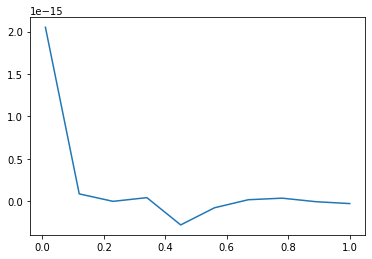

In [ ]:
yy = []    
xx = numpy.r_[0.01:1:10j]
for ii in xx:
    yy.append(measure_perf([ii]))
    
yy = numpy.array(yy)
plt.plot(xx,yy)

In [ ]:
result = scipy.optimize.minimize(measure_perf,[.1],method='powell',bounds=[(.1,1)])
best = result.x

/usr/local/lib/python3.7/dist-packages/scipy/optimize/_minimize.py:522: RuntimeWarning: Method powell cannot handle constraints nor bounds.
  RuntimeWarning)
2022-04-28 05:20:55,986 - pynamics.integration - INFO - beginning integration


k:  0.1


2022-04-28 05:21:00,986 - pynamics.integration - INFO - finished integration
2022-04-28 05:21:00,992 - pynamics.integration - INFO - beginning integration


k:  0.1


2022-04-28 05:21:06,104 - pynamics.integration - INFO - finished integration
2022-04-28 05:21:06,107 - pynamics.integration - INFO - beginning integration


k:  1.1


2022-04-28 05:21:12,493 - pynamics.integration - INFO - finished integration
2022-04-28 05:21:12,500 - pynamics.integration - INFO - beginning integration


k:  2.718034


2022-04-28 05:21:22,046 - pynamics.integration - INFO - finished integration
2022-04-28 05:21:22,051 - pynamics.integration - INFO - beginning integration


k:  1.9241803790093335


2022-04-28 05:21:30,728 - pynamics.integration - INFO - finished integration
2022-04-28 05:21:30,733 - pynamics.integration - INFO - beginning integration


k:  1.1


2022-04-28 05:21:37,026 - pynamics.integration - INFO - finished integration
2022-04-28 05:21:37,035 - pynamics.integration - INFO - beginning integration


k:  0.718034


2022-04-28 05:21:43,667 - pynamics.integration - INFO - finished integration
2022-04-28 05:21:43,675 - pynamics.integration - INFO - beginning integration


k:  1.414808882648679


2022-04-28 05:21:52,070 - pynamics.integration - INFO - finished integration
2022-04-28 05:21:52,078 - pynamics.integration - INFO - beginning integration


k:  1.6093714756275728


2022-04-28 05:21:58,859 - pynamics.integration - INFO - finished integration
2022-04-28 05:21:58,862 - pynamics.integration - INFO - beginning integration


k:  1.3566471539771907


2022-04-28 05:22:06,302 - pynamics.integration - INFO - finished integration
2022-04-28 05:22:06,313 - pynamics.integration - INFO - beginning integration


k:  1.4279569714851659


2022-04-28 05:22:13,477 - pynamics.integration - INFO - finished integration
2022-04-28 05:22:13,484 - pynamics.integration - INFO - beginning integration


k:  1.3925930797949453


2022-04-28 05:22:21,070 - pynamics.integration - INFO - finished integration
2022-04-28 05:22:21,075 - pynamics.integration - INFO - beginning integration


k:  2.729617765297358


2022-04-28 05:22:30,132 - pynamics.integration - INFO - finished integration
2022-04-28 05:22:30,138 - pynamics.integration - INFO - beginning integration


k:  1.414808882648679


2022-04-28 05:22:37,587 - pynamics.integration - INFO - finished integration
2022-04-28 05:22:37,598 - pynamics.integration - INFO - beginning integration


k:  2.729617765297358


2022-04-28 05:22:46,363 - pynamics.integration - INFO - finished integration
2022-04-28 05:22:46,372 - pynamics.integration - INFO - beginning integration


k:  -0.7125965929788938


2022-04-28 05:22:53,480 - pynamics.integration - INFO - finished integration
2022-04-28 05:22:53,488 - pynamics.integration - INFO - beginning integration


k:  1.414808882648679


2022-04-28 05:23:01,059 - pynamics.integration - INFO - finished integration
2022-04-28 05:23:01,062 - pynamics.integration - INFO - beginning integration


k:  0.6022123227451176


2022-04-28 05:23:07,564 - pynamics.integration - INFO - finished integration
2022-04-28 05:23:07,574 - pynamics.integration - INFO - beginning integration


k:  1.9170211723184645


2022-04-28 05:23:17,054 - pynamics.integration - INFO - finished integration
2022-04-28 05:23:17,063 - pynamics.integration - INFO - beginning integration


k:  1.1804788357467497


2022-04-28 05:23:23,012 - pynamics.integration - INFO - finished integration
2022-04-28 05:23:23,019 - pynamics.integration - INFO - beginning integration


k:  1.6066369020846885


2022-04-28 05:23:29,695 - pynamics.integration - INFO - finished integration
2022-04-28 05:23:29,698 - pynamics.integration - INFO - beginning integration


k:  1.3253027719537367


2022-04-28 05:23:37,674 - pynamics.integration - INFO - finished integration
2022-04-28 05:23:37,678 - pynamics.integration - INFO - beginning integration


k:  1.488080663920574


2022-04-28 05:23:44,734 - pynamics.integration - INFO - finished integration
2022-04-28 05:23:44,738 - pynamics.integration - INFO - beginning integration


k:  1.3806205915709748


2022-04-28 05:23:52,399 - pynamics.integration - INFO - finished integration
2022-04-28 05:23:52,404 - pynamics.integration - INFO - beginning integration


k:  1.4427962118539797


2022-04-28 05:23:59,375 - pynamics.integration - INFO - finished integration
2022-04-28 05:23:59,383 - pynamics.integration - INFO - beginning integration


k:  1.4017501178588927


2022-04-28 05:24:06,929 - pynamics.integration - INFO - finished integration
2022-04-28 05:24:06,938 - pynamics.integration - INFO - beginning integration


k:  1.4254990908359109


2022-04-28 05:24:14,488 - pynamics.integration - INFO - finished integration
2022-04-28 05:24:14,498 - pynamics.integration - INFO - beginning integration


k:  1.4098208784969835


2022-04-28 05:24:22,999 - pynamics.integration - INFO - finished integration
2022-04-28 05:24:23,001 - pynamics.integration - INFO - beginning integration


k:  1.409712634775578


2022-04-28 05:24:30,526 - pynamics.integration - INFO - finished integration
2022-04-28 05:24:30,531 - pynamics.integration - INFO - beginning integration


k:  1.4098707585516486


2022-04-28 05:24:38,027 - pynamics.integration - INFO - finished integration
2022-04-28 05:24:38,041 - pynamics.integration - INFO - beginning integration


k:  1.4097709984423186


2022-04-28 05:24:45,567 - pynamics.integration - INFO - finished integration
2022-04-28 05:24:45,579 - pynamics.integration - INFO - beginning integration


k:  1.4098208784969835


2022-04-28 05:24:53,157 - pynamics.integration - INFO - finished integration
2022-04-28 05:24:53,169 - pynamics.integration - INFO - beginning integration


k:  1.4048328743452878


2022-04-28 05:25:01,149 - pynamics.integration - INFO - finished integration
2022-04-28 05:25:01,153 - pynamics.integration - INFO - beginning integration


k:  1.417891638806568


2022-04-28 05:25:08,838 - pynamics.integration - INFO - finished integration
2022-04-28 05:25:08,843 - pynamics.integration - INFO - beginning integration


k:  1.4098208784969835


2022-04-28 05:25:16,639 - pynamics.integration - INFO - finished integration
2022-04-28 05:25:16,645 - pynamics.integration - INFO - beginning integration


k:  1.4129036345293942


2022-04-28 05:25:24,240 - pynamics.integration - INFO - finished integration
2022-04-28 05:25:24,245 - pynamics.integration - INFO - beginning integration


k:  1.4079156305031768


2022-04-28 05:25:32,565 - pynamics.integration - INFO - finished integration
2022-04-28 05:25:32,575 - pynamics.integration - INFO - beginning integration


k:  1.410422630858127


2022-04-28 05:25:40,791 - pynamics.integration - INFO - finished integration
2022-04-28 05:25:40,797 - pynamics.integration - INFO - beginning integration


k:  1.409093138541781


2022-04-28 05:25:48,335 - pynamics.integration - INFO - finished integration
2022-04-28 05:25:48,343 - pynamics.integration - INFO - beginning integration


k:  1.4095429065772547


2022-04-28 05:25:55,818 - pynamics.integration - INFO - finished integration
2022-04-28 05:25:55,822 - pynamics.integration - INFO - beginning integration


k:  1.4100507274393599


2022-04-28 05:26:03,238 - pynamics.integration - INFO - finished integration
2022-04-28 05:26:03,242 - pynamics.integration - INFO - beginning integration


k:  1.4098544486452855


2022-04-28 05:26:10,830 - pynamics.integration - INFO - finished integration
2022-04-28 05:26:10,834 - pynamics.integration - INFO - beginning integration


k:  1.4097147026746923


2022-04-28 05:26:18,373 - pynamics.integration - INFO - finished integration
2022-04-28 05:26:18,377 - pynamics.integration - INFO - beginning integration


k:  1.4097803229428463


2022-04-28 05:26:26,054 - pynamics.integration - INFO - finished integration
2022-04-28 05:26:26,066 - pynamics.integration - INFO - beginning integration


k:  1.4098053876541918


2022-04-28 05:26:34,481 - pynamics.integration - INFO - finished integration
2022-04-28 05:26:34,485 - pynamics.integration - INFO - beginning integration


k:  1.4098337011522497


2022-04-28 05:26:41,912 - pynamics.integration - INFO - finished integration
2022-04-28 05:26:41,923 - pynamics.integration - INFO - beginning integration


k:  1.4098149615217257


2022-04-28 05:26:49,701 - pynamics.integration - INFO - finished integration
2022-04-28 05:26:49,712 - pynamics.integration - INFO - beginning integration


k:  1.409825776315325


2022-04-28 05:27:02,398 - pynamics.integration - INFO - finished integration
2022-04-28 05:27:02,401 - pynamics.integration - INFO - beginning integration


k:  1.4098186184136121


2022-04-28 05:27:12,283 - pynamics.integration - INFO - finished integration
2022-04-28 05:27:12,293 - pynamics.integration - INFO - beginning integration


k:  1.409822749297064


2022-04-28 05:27:20,042 - pynamics.integration - INFO - finished integration
2022-04-28 05:27:20,048 - pynamics.integration - INFO - beginning integration


k:  1.4098200152219784


2022-04-28 05:27:27,712 - pynamics.integration - INFO - finished integration
2022-04-28 05:27:27,717 - pynamics.integration - INFO - beginning integration


k:  1.409821593079007


2022-04-28 05:27:35,304 - pynamics.integration - INFO - finished integration
2022-04-28 05:27:35,316 - pynamics.integration - INFO - beginning integration


k:  1.4098205487552828


2022-04-28 05:27:42,928 - pynamics.integration - INFO - finished integration
2022-04-28 05:27:42,936 - pynamics.integration - INFO - beginning integration


k:  1.4098211514430208


2022-04-28 05:27:50,843 - pynamics.integration - INFO - finished integration
2022-04-28 05:27:50,853 - pynamics.integration - INFO - beginning integration


k:  1.4098207525468651


2022-04-28 05:27:58,502 - pynamics.integration - INFO - finished integration
2022-04-28 05:27:58,506 - pynamics.integration - INFO - beginning integration


k:  1.4098209827530894


2022-04-28 05:28:06,233 - pynamics.integration - INFO - finished integration
2022-04-28 05:28:06,242 - pynamics.integration - INFO - beginning integration


k:  1.4098208303883206


2022-04-28 05:28:13,842 - pynamics.integration - INFO - finished integration
2022-04-28 05:28:13,850 - pynamics.integration - INFO - beginning integration


k:  1.4098209183192714


2022-04-28 05:28:21,483 - pynamics.integration - INFO - finished integration
2022-04-28 05:28:21,488 - pynamics.integration - INFO - beginning integration


k:  1.409820942930799


2022-04-28 05:28:29,074 - pynamics.integration - INFO - finished integration
2022-04-28 05:28:29,079 - pynamics.integration - INFO - beginning integration


k:  1.4098209031085114


2022-04-28 05:28:36,592 - pynamics.integration - INFO - finished integration
2022-04-28 05:28:36,603 - pynamics.integration - INFO - beginning integration


k:  1.4098209277200382


2022-04-28 05:28:44,185 - pynamics.integration - INFO - finished integration
2022-04-28 05:28:44,192 - pynamics.integration - INFO - beginning integration


k:  1.4098209125092782


2022-04-28 05:28:51,822 - pynamics.integration - INFO - finished integration
2022-04-28 05:28:51,825 - pynamics.integration - INFO - beginning integration


k:  1.4098209219100446


2022-04-28 05:28:59,365 - pynamics.integration - INFO - finished integration
2022-04-28 05:28:59,374 - pynamics.integration - INFO - beginning integration


k:  1.4098209161000514


2022-04-28 05:29:07,845 - pynamics.integration - INFO - finished integration
2022-04-28 05:29:07,858 - pynamics.integration - INFO - beginning integration


k:  1.4098209196908247


2022-04-28 05:29:15,369 - pynamics.integration - INFO - finished integration
2022-04-28 05:29:15,371 - pynamics.integration - INFO - beginning integration


k:  1.4098209174716048


2022-04-28 05:29:22,890 - pynamics.integration - INFO - finished integration
2022-04-28 05:29:22,893 - pynamics.integration - INFO - beginning integration


k:  1.409820918843158


2022-04-28 05:29:30,616 - pynamics.integration - INFO - finished integration
2022-04-28 05:29:30,627 - pynamics.integration - INFO - beginning integration


k:  1.4098209179209984


2022-04-28 05:29:38,202 - pynamics.integration - INFO - finished integration
2022-04-28 05:29:38,207 - pynamics.integration - INFO - beginning integration


k:  1.4048329539898636


2022-04-28 05:29:46,182 - pynamics.integration - INFO - finished integration
2022-04-28 05:29:46,186 - pynamics.integration - INFO - beginning integration


k:  1.4098209183192714


2022-04-28 05:29:53,661 - pynamics.integration - INFO - finished integration
2022-04-28 05:29:53,672 - pynamics.integration - INFO - beginning integration


k:  1.4048329141675757


2022-04-28 05:30:01,645 - pynamics.integration - INFO - finished integration
2022-04-28 05:30:01,649 - pynamics.integration - INFO - beginning integration


k:  1.417891678628856


2022-04-28 05:30:09,178 - pynamics.integration - INFO - finished integration
2022-04-28 05:30:09,182 - pynamics.integration - INFO - beginning integration


k:  1.4098209183192714


2022-04-28 05:30:17,784 - pynamics.integration - INFO - finished integration
2022-04-28 05:30:17,796 - pynamics.integration - INFO - beginning integration


k:  1.412903674351682


2022-04-28 05:30:25,293 - pynamics.integration - INFO - finished integration
2022-04-28 05:30:25,297 - pynamics.integration - INFO - beginning integration


k:  1.4079156703254647


2022-04-28 05:30:32,806 - pynamics.integration - INFO - finished integration
2022-04-28 05:30:32,815 - pynamics.integration - INFO - beginning integration


k:  1.4104365546445328


2022-04-28 05:30:40,410 - pynamics.integration - INFO - finished integration
2022-04-28 05:30:40,418 - pynamics.integration - INFO - beginning integration


k:  1.409093178364069


2022-04-28 05:30:48,221 - pynamics.integration - INFO - finished integration
2022-04-28 05:30:48,224 - pynamics.integration - INFO - beginning integration


k:  1.4095429463995426


2022-04-28 05:30:55,866 - pynamics.integration - INFO - finished integration
2022-04-28 05:30:55,875 - pynamics.integration - INFO - beginning integration


k:  1.4100560704638863


2022-04-28 05:31:03,833 - pynamics.integration - INFO - finished integration
2022-04-28 05:31:03,846 - pynamics.integration - INFO - beginning integration


k:  1.4097147424969803


2022-04-28 05:31:11,441 - pynamics.integration - INFO - finished integration
2022-04-28 05:31:11,446 - pynamics.integration - INFO - beginning integration


k:  1.4099107384433414


2022-04-28 05:31:19,174 - pynamics.integration - INFO - finished integration
2022-04-28 05:31:19,180 - pynamics.integration - INFO - beginning integration


k:  1.4097803627651342


2022-04-28 05:31:26,659 - pynamics.integration - INFO - finished integration
2022-04-28 05:31:26,663 - pynamics.integration - INFO - beginning integration


k:  1.409855226552782


2022-04-28 05:31:34,155 - pynamics.integration - INFO - finished integration
2022-04-28 05:31:34,160 - pynamics.integration - INFO - beginning integration


k:  1.4098054274764797


2022-04-28 05:31:41,699 - pynamics.integration - INFO - finished integration
2022-04-28 05:31:41,712 - pynamics.integration - INFO - beginning integration


k:  1.4098340228979924


2022-04-28 05:31:49,331 - pynamics.integration - INFO - finished integration
2022-04-28 05:31:49,343 - pynamics.integration - INFO - beginning integration


k:  1.4098150013440136


2022-04-28 05:31:56,975 - pynamics.integration - INFO - finished integration
2022-04-28 05:31:56,988 - pynamics.integration - INFO - beginning integration


k:  1.409825923822787


2022-04-28 05:32:04,728 - pynamics.integration - INFO - finished integration
2022-04-28 05:32:04,741 - pynamics.integration - INFO - beginning integration


k:  1.4098186582359


2022-04-28 05:32:12,359 - pynamics.integration - INFO - finished integration
2022-04-28 05:32:12,368 - pynamics.integration - INFO - beginning integration


k:  1.4098228302514273


2022-04-28 05:32:20,058 - pynamics.integration - INFO - finished integration
2022-04-28 05:32:20,072 - pynamics.integration - INFO - beginning integration


k:  1.4098200550442663


2022-04-28 05:32:27,632 - pynamics.integration - INFO - finished integration
2022-04-28 05:32:27,646 - pynamics.integration - INFO - beginning integration


k:  1.4098216486123492


2022-04-28 05:32:36,253 - pynamics.integration - INFO - finished integration
2022-04-28 05:32:36,261 - pynamics.integration - INFO - beginning integration


k:  1.4098205885775708


2022-04-28 05:32:43,882 - pynamics.integration - INFO - finished integration
2022-04-28 05:32:43,885 - pynamics.integration - INFO - beginning integration


k:  1.4098211972663972


2022-04-28 05:32:51,582 - pynamics.integration - INFO - finished integration
2022-04-28 05:32:51,585 - pynamics.integration - INFO - beginning integration


k:  1.409820792369153


2022-04-28 05:32:59,239 - pynamics.integration - INFO - finished integration
2022-04-28 05:32:59,251 - pynamics.integration - INFO - beginning integration


k:  1.4098210248675893


2022-04-28 05:33:06,800 - pynamics.integration - INFO - finished integration
2022-04-28 05:33:06,805 - pynamics.integration - INFO - beginning integration


k:  1.4098208702106085


2022-04-28 05:33:14,447 - pynamics.integration - INFO - finished integration
2022-04-28 05:33:14,451 - pynamics.integration - INFO - beginning integration


k:  1.4098209590171062


2022-04-28 05:33:22,118 - pynamics.integration - INFO - finished integration
2022-04-28 05:33:22,129 - pynamics.integration - INFO - beginning integration


k:  1.4098208999433979


2022-04-28 05:33:29,665 - pynamics.integration - INFO - finished integration
2022-04-28 05:33:29,668 - pynamics.integration - INFO - beginning integration


k:  1.4098209338644605


2022-04-28 05:33:37,107 - pynamics.integration - INFO - finished integration
2022-04-28 05:33:37,109 - pynamics.integration - INFO - beginning integration


k:  1.4098209113003124


2022-04-28 05:33:44,712 - pynamics.integration - INFO - finished integration
2022-04-28 05:33:44,715 - pynamics.integration - INFO - beginning integration


k:  1.409820924257005


2022-04-28 05:33:52,438 - pynamics.integration - INFO - finished integration
2022-04-28 05:33:52,449 - pynamics.integration - INFO - beginning integration


k:  1.4098209156382677


2022-04-28 05:34:01,194 - pynamics.integration - INFO - finished integration
2022-04-28 05:34:01,197 - pynamics.integration - INFO - beginning integration


k:  1.4098209205872838


2022-04-28 05:34:08,679 - pynamics.integration - INFO - finished integration
2022-04-28 05:34:08,683 - pynamics.integration - INFO - beginning integration


k:  1.4098209172952192


2022-04-28 05:34:16,364 - pynamics.integration - INFO - finished integration
2022-04-28 05:34:16,377 - pynamics.integration - INFO - beginning integration


k:  1.409820919185575


2022-04-28 05:34:25,347 - pynamics.integration - INFO - finished integration
2022-04-28 05:34:25,358 - pynamics.integration - INFO - beginning integration


k:  1.4098209179281183


2022-04-28 05:34:34,014 - pynamics.integration - INFO - finished integration
2022-04-28 05:34:34,028 - pynamics.integration - INFO - beginning integration


k:  1.4098209186501698


2022-04-28 05:34:41,145 - pynamics.integration - INFO - finished integration
2022-04-28 05:34:41,152 - pynamics.integration - INFO - beginning integration


k:  1.4098209181698642


2022-04-28 05:34:45,181 - pynamics.integration - INFO - finished integration
2022-04-28 05:34:45,185 - pynamics.integration - INFO - beginning integration


k:  1.4098209184456634


2022-04-28 05:34:49,224 - pynamics.integration - INFO - finished integration
2022-04-28 05:34:49,227 - pynamics.integration - INFO - beginning integration


k:  1.4098209182622028


2022-04-28 05:34:53,249 - pynamics.integration - INFO - finished integration
2022-04-28 05:34:53,252 - pynamics.integration - INFO - beginning integration


k:  1.4098209183675487


2022-04-28 05:34:57,266 - pynamics.integration - INFO - finished integration
2022-04-28 05:34:57,270 - pynamics.integration - INFO - beginning integration


k:  1.4098209182974732


2022-04-28 05:35:01,335 - pynamics.integration - INFO - finished integration
2022-04-28 05:35:01,341 - pynamics.integration - INFO - beginning integration


k:  1.4098209183377117


2022-04-28 05:35:05,325 - pynamics.integration - INFO - finished integration
2022-04-28 05:35:05,328 - pynamics.integration - INFO - beginning integration


k:  1.4098209183109451


2022-04-28 05:35:10,936 - pynamics.integration - INFO - finished integration
2022-04-28 05:35:10,938 - pynamics.integration - INFO - beginning integration


k:  1.4098209183263148


2022-04-28 05:35:14,931 - pynamics.integration - INFO - finished integration
2022-04-28 05:35:14,936 - pynamics.integration - INFO - beginning integration


k:  1.409820918316091


2022-04-28 05:35:18,944 - pynamics.integration - INFO - finished integration
2022-04-28 05:35:18,946 - pynamics.integration - INFO - beginning integration


k:  1.4098209183219619


2022-04-28 05:35:22,944 - pynamics.integration - INFO - finished integration
2022-04-28 05:35:22,946 - pynamics.integration - INFO - beginning integration


k:  1.4098209183180566


2022-04-28 05:35:26,944 - pynamics.integration - INFO - finished integration
2022-04-28 05:35:26,946 - pynamics.integration - INFO - beginning integration


k:  1.409820918320299


2022-04-28 05:35:30,874 - pynamics.integration - INFO - finished integration
2022-04-28 05:35:30,880 - pynamics.integration - INFO - beginning integration


k:  1.4098209183188073


2022-04-28 05:35:34,810 - pynamics.integration - INFO - finished integration
2022-04-28 05:35:34,813 - pynamics.integration - INFO - beginning integration


k:  1.409820918319664


2022-04-28 05:35:38,890 - pynamics.integration - INFO - finished integration
2022-04-28 05:35:38,892 - pynamics.integration - INFO - beginning integration


k:  1.4098209183190942


2022-04-28 05:35:43,056 - pynamics.integration - INFO - finished integration
2022-04-28 05:35:43,062 - pynamics.integration - INFO - beginning integration


k:  1.4098209183194212


2022-04-28 05:35:47,275 - pynamics.integration - INFO - finished integration
2022-04-28 05:35:47,277 - pynamics.integration - INFO - beginning integration


k:  1.4098209183192036


2022-04-28 05:35:51,298 - pynamics.integration - INFO - finished integration
2022-04-28 05:35:51,300 - pynamics.integration - INFO - beginning integration


k:  1.4098209183193287


2022-04-28 05:35:55,272 - pynamics.integration - INFO - finished integration


In [ ]:
#states=pynamics.integration.integrate(func1,ini,t,rtol=tol,atol=tol, args=({'constants':system.constant_values},))

In [ ]:
k_optimum = result.x
k_optimum

array(1.40982092)

In [ ]:
states = run([best])

2022-04-28 05:37:37,815 - pynamics.integration - INFO - beginning integration
2022-04-28 05:37:41,922 - pynamics.integration - INFO - finished integration


2022-04-28 05:38:44,445 - pynamics.output - INFO - calculating outputs
2022-04-28 05:38:44,564 - pynamics.output - INFO - done calculating outputs


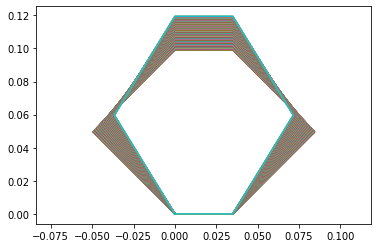

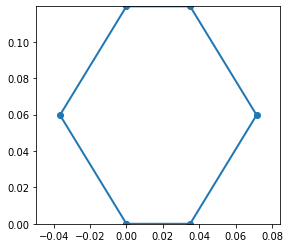

In [ ]:
po = PointsOutput(points,system)
po.calc(states,t)
po.plot_time()
po.animate(fps = 30, movie_name='muscle.mp4',lw=2,marker='o')

In [ ]:
from matplotlib import animation, rc
from IPython.display import HTML
HTML(po.anim.to_html5_video())

## Experimental Setup for data collection of Stiffness

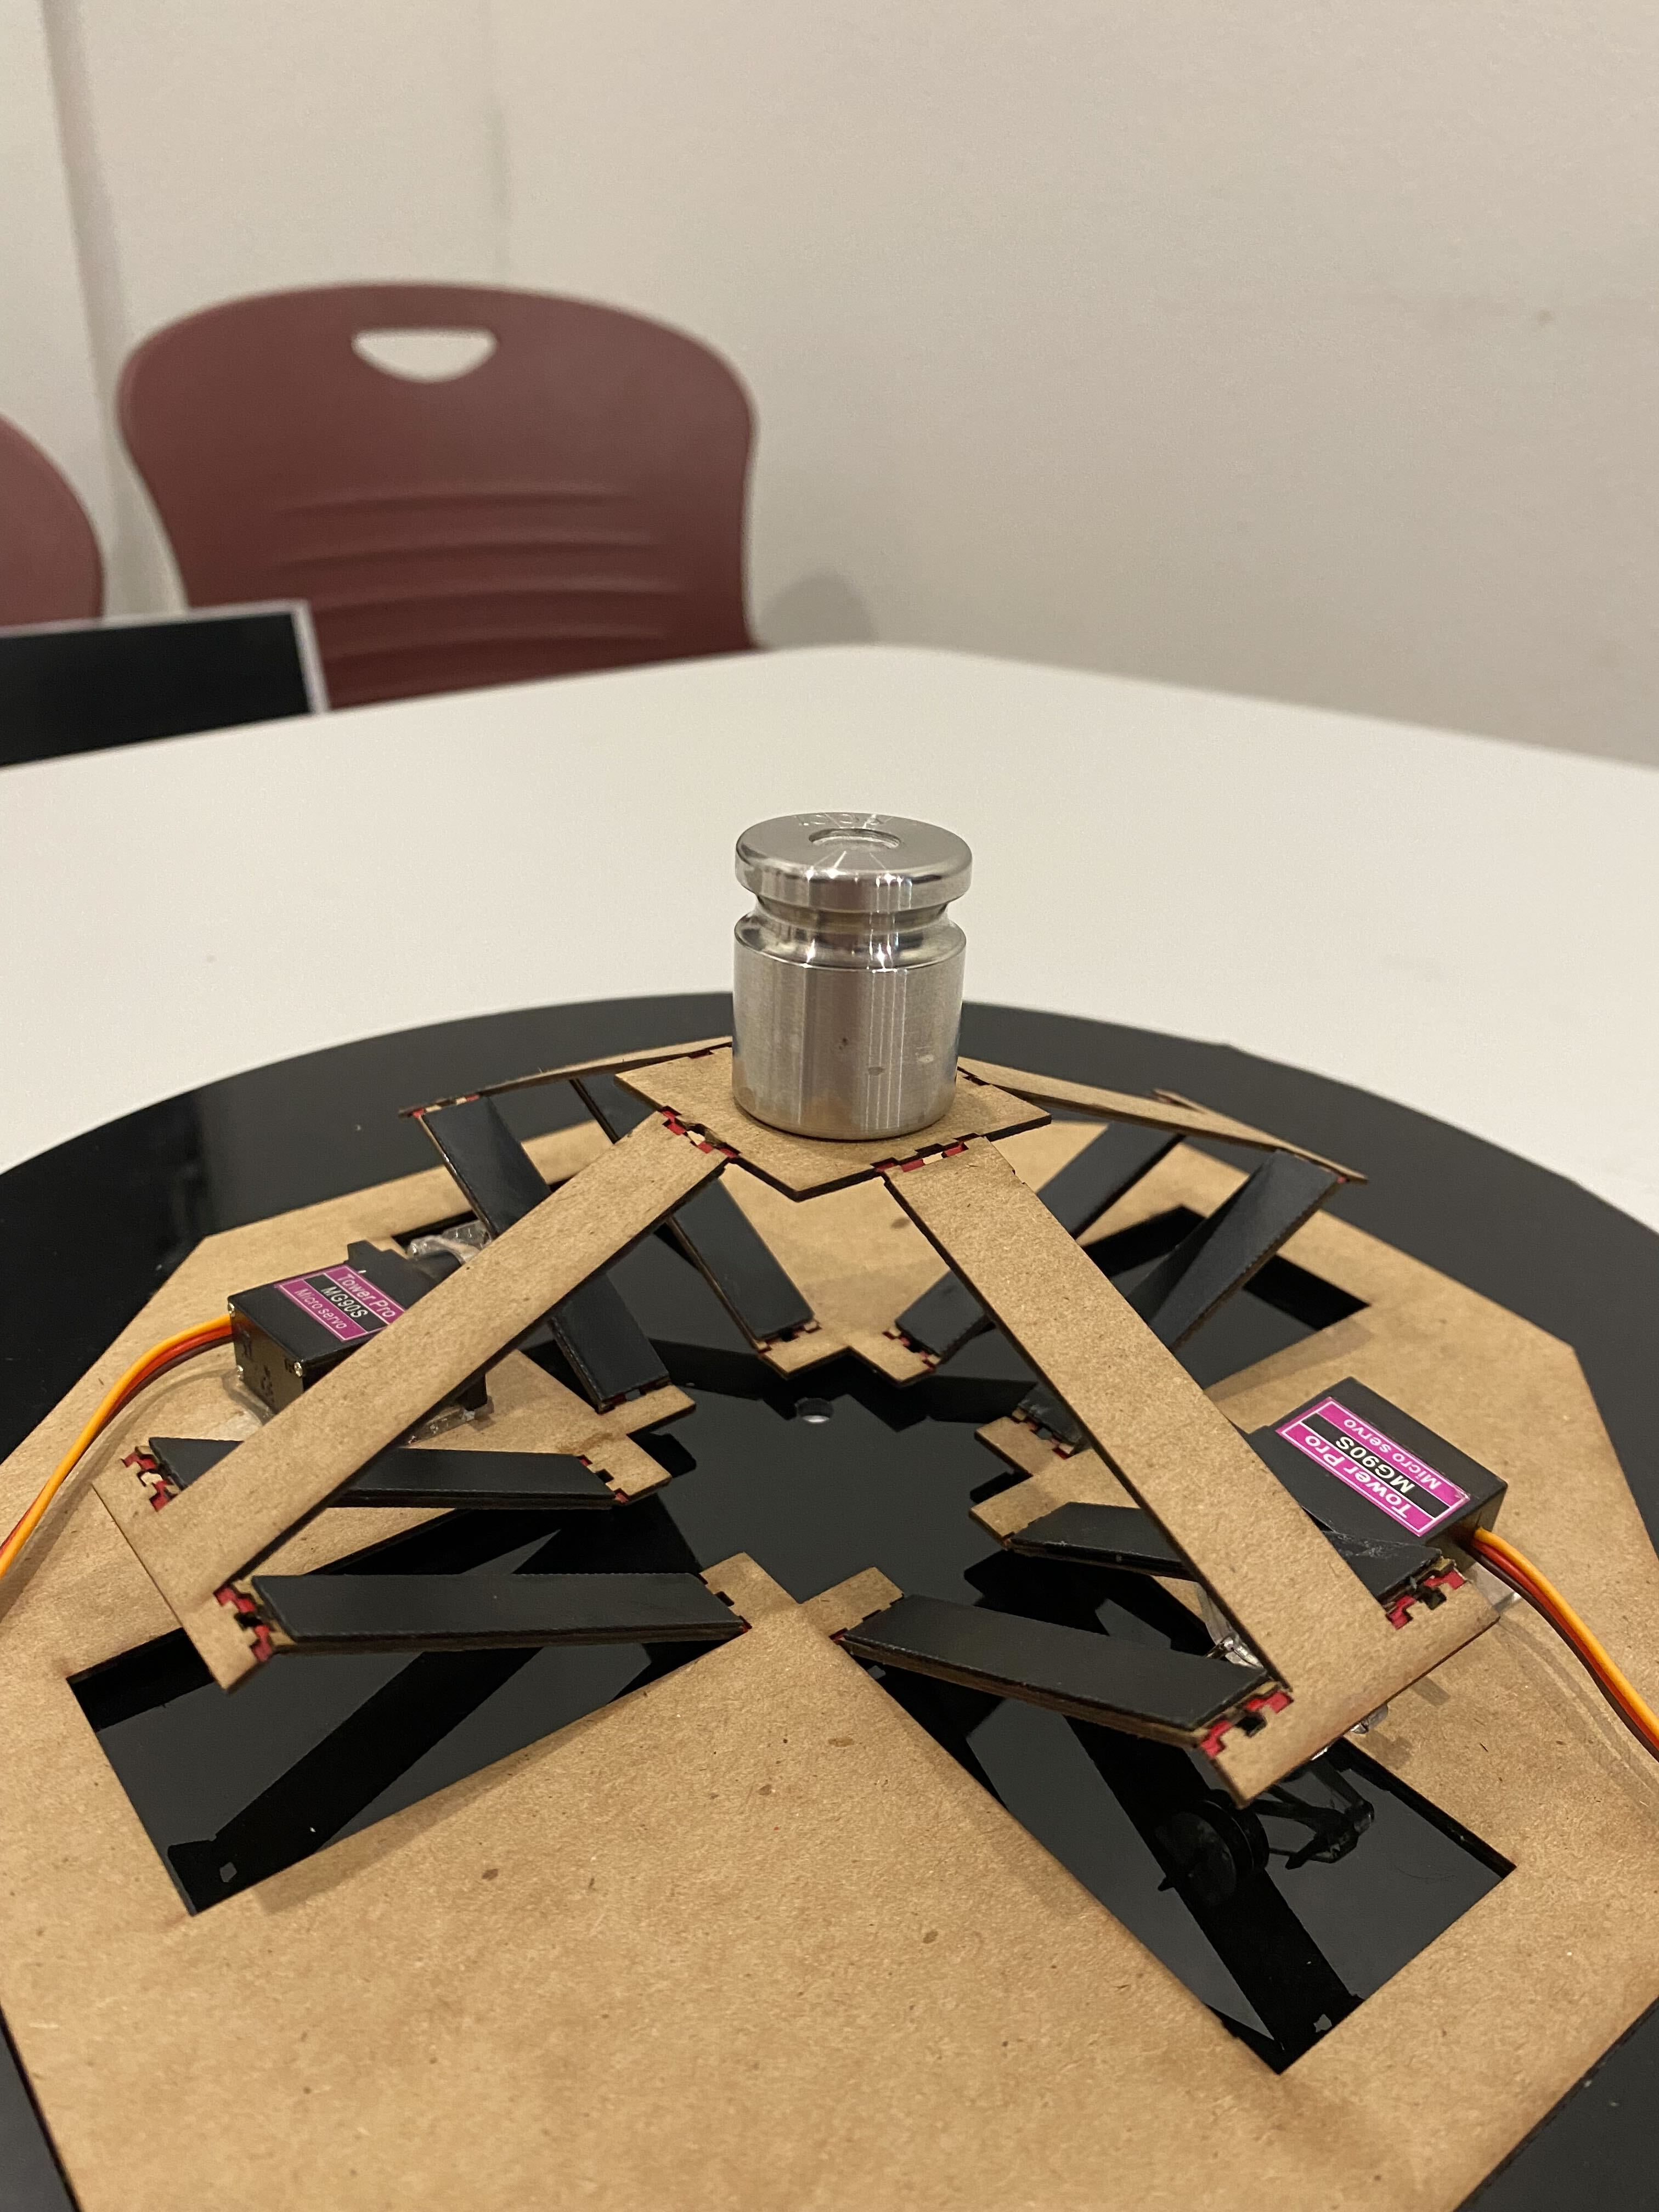

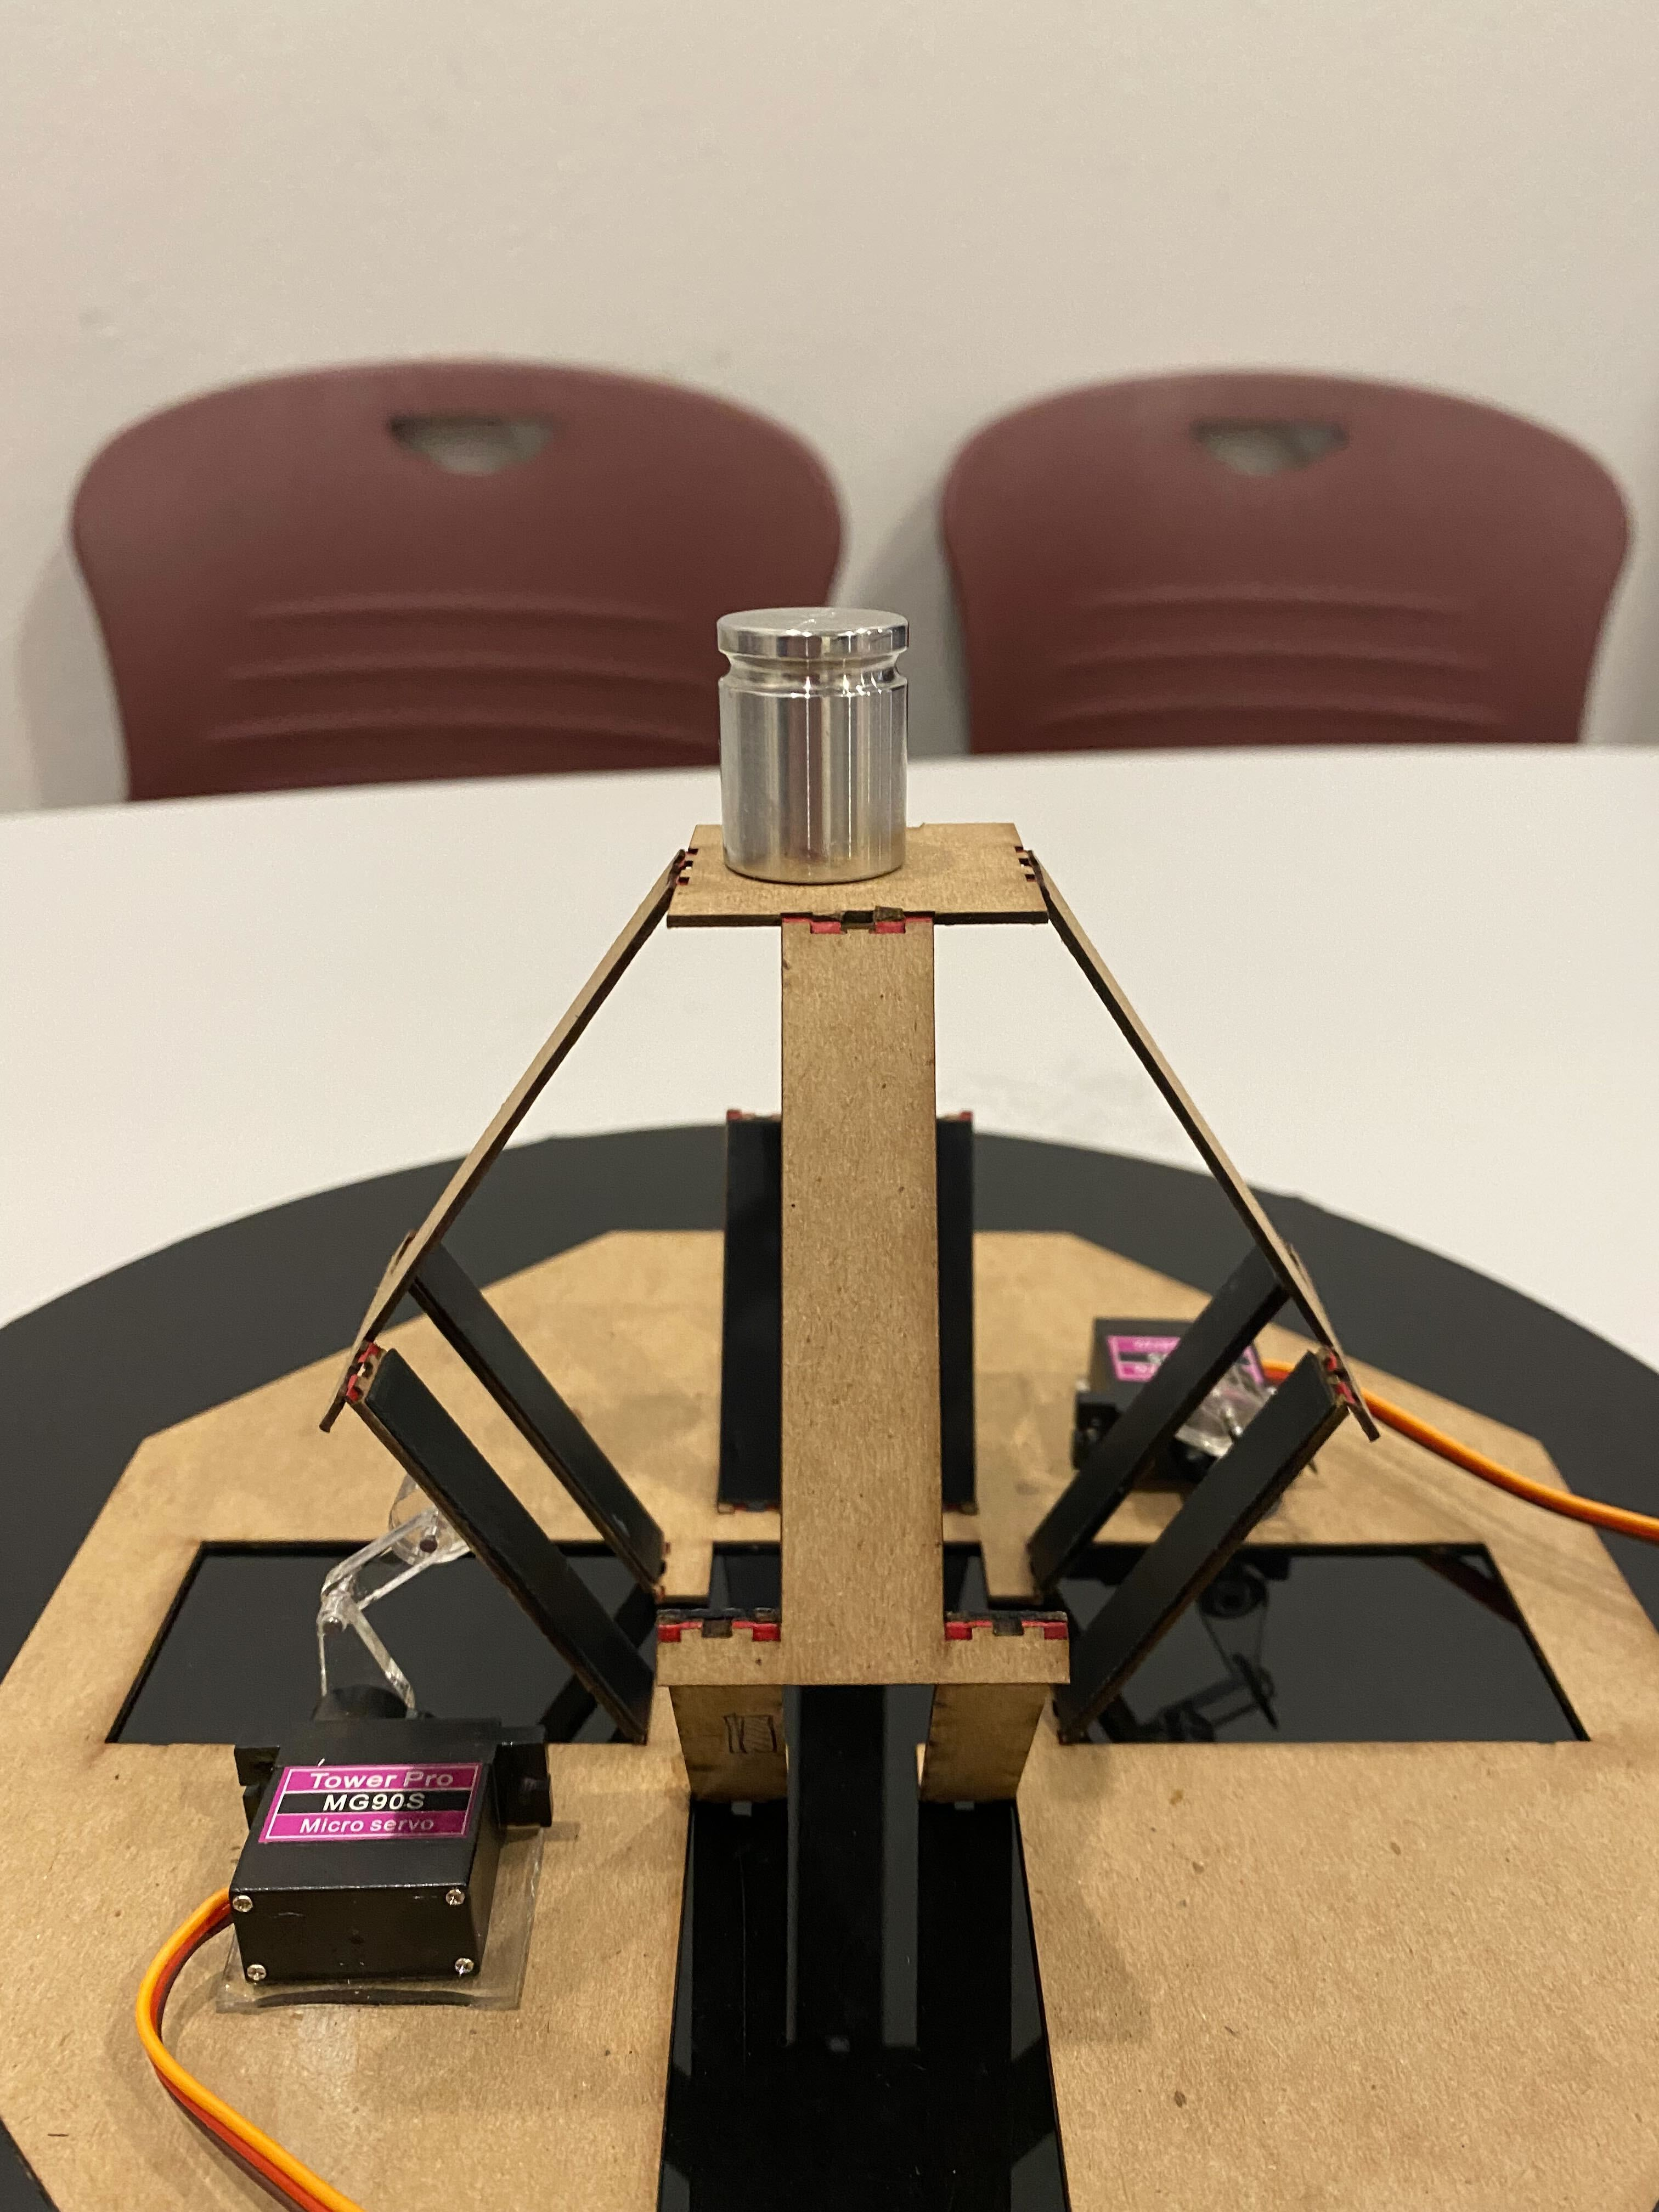

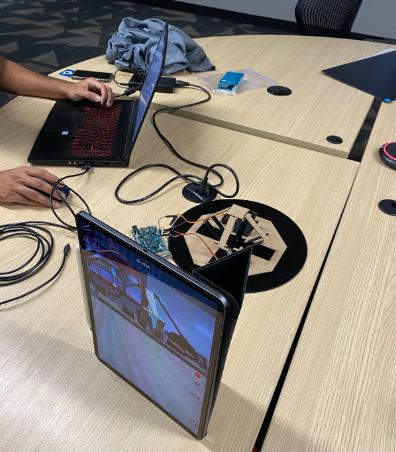